## Option Chain Processing with YF 

This notebook demonstrates the following workflow: 
1. Fetch option chain from yf
2. Explore the data structure  
3. Visualize the prices, volumes, and open interests
4. Caclulate basic Greeks
5. Analyze implied vol

For this particular example we use S&P500 and AAPL

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../src')
from datetime import datetime, timedelta
import plotly.graph_objects as go

pd.options.display.float_format = "{:,.4f}".format
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Import our custom pricing functions
import sys
sys.path.append('../src')
from options_desk.pricing.black_scholes import (
    black_scholes_price,
    black_scholes_delta,
    black_scholes_gamma,
    black_scholes_vega,
    black_scholes_theta
)
from options_desk.core.option import OptionType

In [2]:

spy = yf.Ticker('SPY')
stock_prices = spy.history(period='5d')
current_price = stock_prices['Close'].iloc[-1]

stock_prices[['Close', 'Volume']].tail()

,Close,Volume
Date,,
2025-11-03 00:00:00-05:00,683.3400,57315000
2025-11-04 00:00:00-05:00,675.2400,78427000
2025-11-05 00:00:00-05:00,677.5800,74402400
2025-11-06 00:00:00-05:00,670.3100,85035300
2025-11-07 00:00:00-05:00,670.9700,100516700


Let's inspect the available expiration dates, which essentially are made by exchanges. 

In [3]:
spy_options = spy.options

print(f"Available expiration dates ({len(spy_options)} total):")
print("\nFirst 10 expiration dates:")
for i, date in enumerate(spy_options[:10], 1):
    exp_date = pd.to_datetime(date)
    days_to_exp = (exp_date - pd.Timestamp.now()).days

    print('{} days'.format(days_to_exp))

Available expiration dates (33 total):

First 10 expiration dates:
0 days
1 days
2 days
3 days
4 days
7 days
8 days
9 days
10 days
11 days


Now we have all those available dates, each date we have a bunch of calls and puts chained with the strike price list.

In [16]:
expiration_dates = spy_options[10]
option_chain = spy.option_chain(expiration_dates)
calls = option_chain.calls
puts = option_chain.puts

expiration_datetime = pd.to_datetime(expiration_dates) 
days_to_expire = (expiration_datetime - pd.Timestamp.now()).days
time_to_expire = days_to_expire / 365.25

days_to_expire


18

Let's further see what the option chain looks like.

In [17]:
atm_puts = puts[puts['strike'].between(current_price * 0.95, current_price * 1.05)]
atm_calls = calls[calls['strike'].between(current_price * 0.95, current_price * 1.05)]
display(atm_puts[['strike', 'lastPrice', 'bid', 'ask', 'volume', 'openInterest', 'impliedVolatility']].head(10))

,strike,lastPrice,bid,ask,volume,openInterest,impliedVolatility
142,638.0000,2.6000,2.3200,2.3500,425.0000,1103,0.2043
143,639.0000,2.6900,2.4100,2.4500,208.0000,753,0.2028
144,640.0000,2.5800,2.5100,2.5400,"2,941.0000",20098,0.2008
145,641.0000,3.2300,2.6100,2.6500,310.0000,1151,0.1993
146,642.0000,2.7700,2.7200,2.7600,390.0000,867,0.1977
147,643.0000,3.4100,2.8300,2.8700,185.0000,1669,0.1959
148,644.0000,2.9800,2.9500,2.9900,575.0000,447,0.1943
149,645.0000,3.1500,3.0700,3.1100,"1,024.0000",8692,0.1925
150,646.0000,4.2300,3.2000,3.2400,289.0000,912,0.1909
151,647.0000,3.4000,3.3300,3.3700,512.0000,1014,0.1891


In [18]:
display(atm_calls[['strike', 'lastPrice', 'bid', 'ask', 'volume', 'openInterest', 'impliedVolatility']].head(10))

,strike,lastPrice,bid,ask,volume,openInterest,impliedVolatility
138,638.0000,36.1800,37.5900,37.7200,21.0000,114,0.2644
139,639.0000,30.9700,36.6800,36.8100,2.0000,76,0.2615
140,640.0000,32.8600,35.7900,35.9100,52.0000,1692,0.2587
141,641.0000,34.6400,34.8900,35.0200,1.0000,51,0.2561
142,642.0000,37.9900,34.0000,34.1300,1.0000,70,0.2534
143,643.0000,31.1200,33.1200,33.2400,3.0000,313,0.2506
144,644.0000,40.2700,32.2400,32.3600,1.0000,628,0.2480
145,645.0000,24.8800,31.3600,31.4800,27.0000,2656,0.2452
146,646.0000,28.7700,30.4900,30.6100,1.0000,213,0.2426
147,647.0000,29.8000,29.6200,29.7400,3.0000,145,0.2399


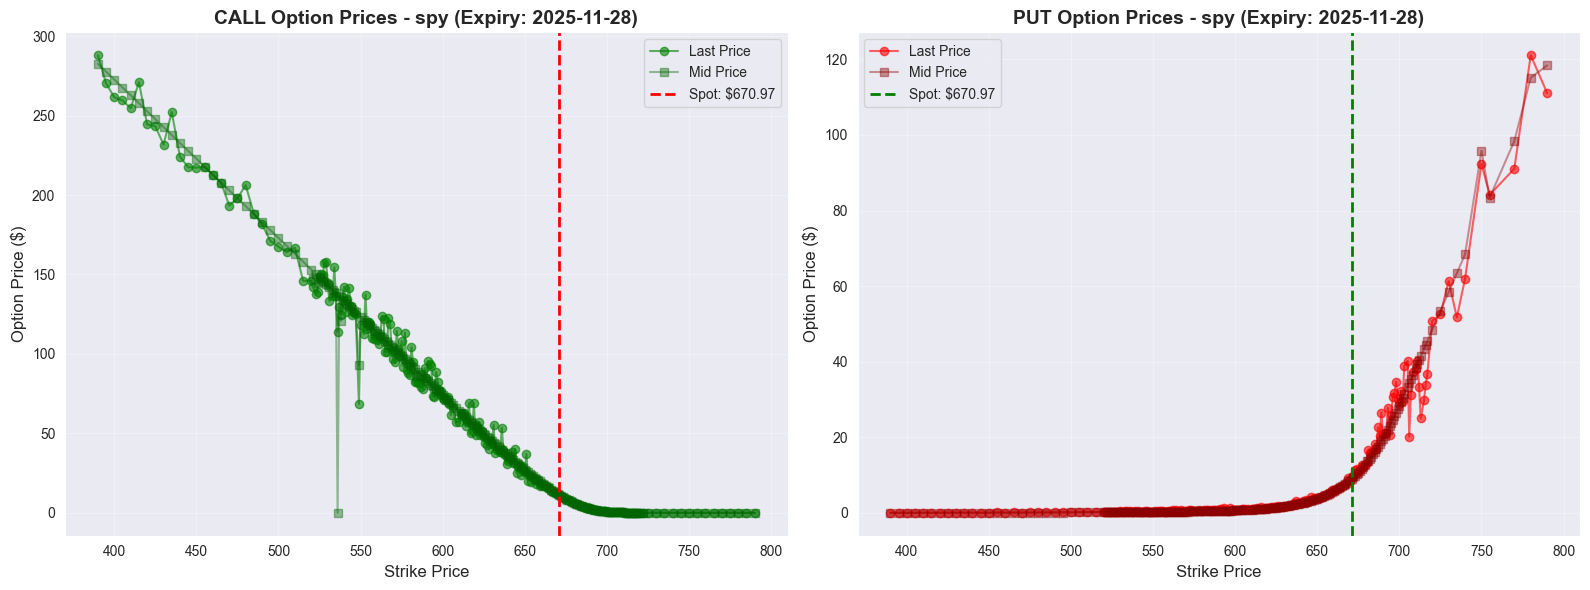

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Call prices
axes[0].plot(calls['strike'], calls['lastPrice'], 'o-', color='green', alpha=0.6, label='Last Price')
axes[0].plot(calls['strike'], (calls['bid'] + calls['ask']) / 2, 's-', color='darkgreen', alpha=0.4, label='Mid Price')
axes[0].axvline(current_price, color='red', linestyle='--', linewidth=2, label=f'Spot: ${current_price:.2f}')
axes[0].set_xlabel('Strike Price', fontsize=12)
axes[0].set_ylabel('Option Price ($)', fontsize=12)
axes[0].set_title(f'CALL Option Prices - {'spy'} (Expiry: {expiration_dates})', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Put prices
axes[1].plot(puts['strike'], puts['lastPrice'], 'o-', color='red', alpha=0.6, label='Last Price')
axes[1].plot(puts['strike'], (puts['bid'] + puts['ask']) / 2, 's-', color='darkred', alpha=0.4, label='Mid Price')
axes[1].axvline(current_price, color='green', linestyle='--', linewidth=2, label=f'Spot: ${current_price:.2f}')
axes[1].set_xlabel('Strike Price', fontsize=12)
axes[1].set_ylabel('Option Price ($)', fontsize=12)
axes[1].set_title(f'PUT Option Prices - {'spy'} (Expiry: {expiration_dates})', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

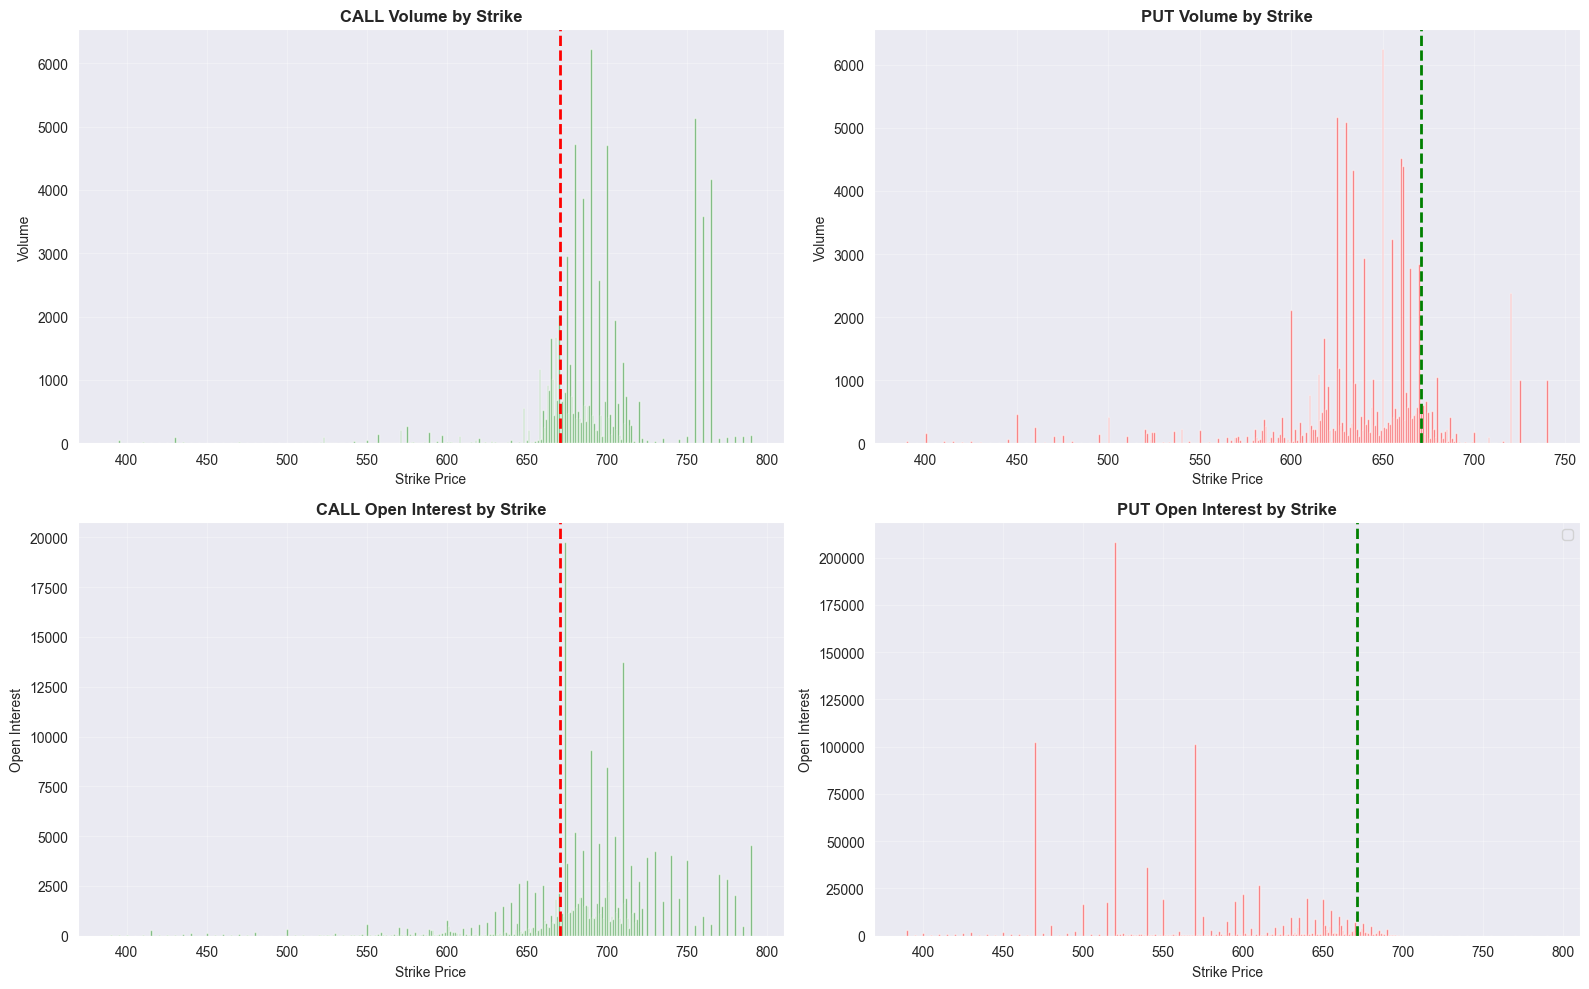

In [23]:
# Plot volume and open interest
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Call volume
axes[0, 0].bar(calls['strike'], calls['volume'], color='green', alpha=0.6, width=1)
axes[0, 0].axvline(current_price, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Strike Price')
axes[0, 0].set_ylabel('Volume')
axes[0, 0].set_title('CALL Volume by Strike', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Put volume
axes[0, 1].bar(puts['strike'], puts['volume'], color='red', alpha=0.6, width=1)
axes[0, 1].axvline(current_price, color='green', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Strike Price')
axes[0, 1].set_ylabel('Volume')
axes[0, 1].set_title('PUT Volume by Strike', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Call open interest
axes[1, 0].bar(calls['strike'], calls['openInterest'], color='green', alpha=0.6, width=1)
axes[1, 0].axvline(current_price, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Strike Price')
axes[1, 0].set_ylabel('Open Interest')
axes[1, 0].set_title('CALL Open Interest by Strike', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Put open interest
axes[1, 1].bar(puts['strike'], puts['openInterest'], color='red', alpha=0.6, width=1)
axes[1, 1].axvline(current_price, color='green', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Strike Price')
axes[1, 1].set_ylabel('Open Interest')
axes[1, 1].set_title('PUT Open Interest by Strike', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

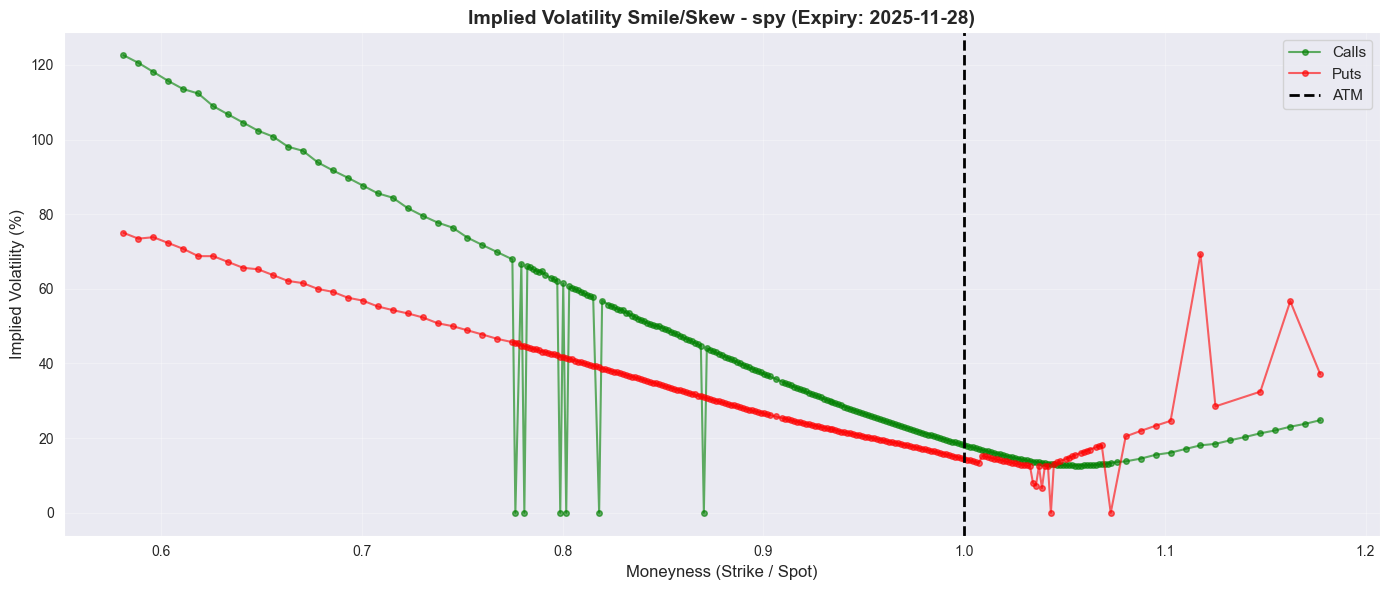


Implied Volatility Statistics:

CALLS:
  Min IV: 0.00%
  Max IV: 122.58%
  Mean IV: 38.30%
  ATM IV: 18.15%

PUTS:
  Min IV: 0.00%
  Max IV: 75.00%
  Mean IV: 29.94%
  ATM IV: 14.47%


In [26]:
# Plot implied volatility smile/skew
fig, ax = plt.subplots(figsize=(14, 6))

# Calculate moneyness (K/S)
calls['moneyness'] = calls['strike'] / current_price
puts['moneyness'] = puts['strike'] / current_price

# Plot IV smile
ax.plot(calls['moneyness'], calls['impliedVolatility'] * 100, 'o-', color='green', 
        alpha=0.6, label='Calls', markersize=4)
ax.plot(puts['moneyness'], puts['impliedVolatility'] * 100, 'o-', color='red', 
        alpha=0.6, label='Puts', markersize=4)
ax.axvline(1.0, color='black', linestyle='--', linewidth=2, label='ATM')

ax.set_xlabel('Moneyness (Strike / Spot)', fontsize=12)
ax.set_ylabel('Implied Volatility (%)', fontsize=12)
ax.set_title(f'Implied Volatility Smile/Skew - {'spy'} (Expiry: {expiration_dates})', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print some statistics
print("\nImplied Volatility Statistics:")
print(f"\nCALLS:")
print(f"  Min IV: {calls['impliedVolatility'].min()*100:.2f}%")
print(f"  Max IV: {calls['impliedVolatility'].max()*100:.2f}%")
print(f"  Mean IV: {calls['impliedVolatility'].mean()*100:.2f}%")
print(f"  ATM IV: {calls.iloc[(calls['strike'] - current_price).abs().argsort()[:1]]['impliedVolatility'].values[0]*100:.2f}%")

print(f"\nPUTS:")
print(f"  Min IV: {puts['impliedVolatility'].min()*100:.2f}%")
print(f"  Max IV: {puts['impliedVolatility'].max()*100:.2f}%")
print(f"  Mean IV: {puts['impliedVolatility'].mean()*100:.2f}%")
print(f"  ATM IV: {puts.iloc[(puts['strike'] - current_price).abs().argsort()[:1]]['impliedVolatility'].values[0]*100:.2f}%")

In [ ]:
# Select ATM options for detailed analysis
atm_strike = calls.iloc[(calls['strike'] - current_price).abs().argsort()[:1]]['strike'].values[0]
atm_call = calls[calls['strike'] == atm_strike].iloc[0]
atm_put = puts[puts['strike'] == atm_strike].iloc[0]

# Use implied volatility from market
iv_call = atm_call['impliedVolatility']
iv_put = atm_put['impliedVolatility']
avg_iv = (iv_call + iv_put) / 2

# Risk-free rate (approximate - you can use Treasury rates)
risk_free_rate = 0.045  # 4.5% - adjust based on current rates

print(f"\n{'='*70}")
print(f"ATM Analysis for Strike: ${atm_strike:.2f}")
print(f"{'='*70}")
print(f"\nCurrent Spot Price: ${current_price:.2f}")
print(f"Time to Expiry: {days_to_expire} days ({time_to_expire:.4f} years)")
print(f"Average Implied Volatility: {avg_iv*100:.2f}%")
print(f"Risk-free Rate: {risk_free_rate*100:.2f}%")

# Calculate theoretical prices and Greeks for CALL
print(f"\n{'='*35} CALL {'='*35}")
call_price_theo = black_scholes_price(
    current_price, atm_strike, time_to_expire, risk_free_rate, avg_iv, OptionType.CALL
)
call_delta = black_scholes_delta(
    current_price, atm_strike, time_to_expire, risk_free_rate, avg_iv, OptionType.CALL
)
call_gamma = black_scholes_gamma(
    current_price, atm_strike, time_to_expire, risk_free_rate, avg_iv
)
call_vega = black_scholes_vega(
    current_price, atm_strike, time_to_expire, risk_free_rate, avg_iv
)
call_theta = black_scholes_theta(
    current_price, atm_strike, time_to_expire, risk_free_rate, avg_iv, OptionType.CALL
)

print(f"Market Price: ${atm_call['lastPrice']:.2f} (bid: ${atm_call['bid']:.2f}, ask: ${atm_call['ask']:.2f})")
print(f"Theoretical Price: ${call_price_theo:.2f}")
print(f"\nGreeks:")
print(f"  Delta: {call_delta:.4f} (price change per $1 move in underlying)")
print(f"  Gamma: {call_gamma:.4f} (delta change per $1 move in underlying)")
print(f"  Vega: {call_vega:.4f} (price change per 1% change in IV)")
print(f"  Theta: {call_theta:.4f} (price change per day)")

# Calculate theoretical prices and Greeks for PUT
print(f"\n{'='*35} PUT {'='*35}")
put_price_theo = black_scholes_price(
    current_price, atm_strike, time_to_expire, risk_free_rate, avg_iv, OptionType.PUT
)
put_delta = black_scholes_delta(
    current_price, atm_strike, time_to_expire, risk_free_rate, avg_iv, OptionType.PUT
)
put_vega = black_scholes_vega(
    current_price, atm_strike, time_to_expire, risk_free_rate, avg_iv
)
put_theta = black_scholes_theta(
    current_price, atm_strike, time_to_expire, risk_free_rate, avg_iv, OptionType.PUT
)

print(f"Market Price: ${atm_put['lastPrice']:.2f} (bid: ${atm_put['bid']:.2f}, ask: ${atm_put['ask']:.2f})")
print(f"Theoretical Price: ${put_price_theo:.2f}")
print(f"\nGreeks:")
print(f"  Delta: {put_delta:.4f} (price change per $1 move in underlying)")
print(f"  Gamma: {call_gamma:.4f} (same as call - gamma is identical for calls and puts)")
print(f"  Vega: {put_vega:.4f} (price change per 1% change in IV)")
print(f"  Theta: {put_theta:.4f} (price change per day)")


ATM Analysis for Strike: $671.00

Current Spot Price: $670.97


NameError: name 'days_to_expiry' is not defined